In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

from collections import Counter
import re

In [2]:
############# Sei

sei_supp_table_1 = pd.read_excel('../data/Sei/41588_2022_1102_MOESM3_ESM.xlsx', sheet_name='Supp Table 1', skiprows=1)
sei_supp_table_1

,Chromatin Profile,AUROC,AUPRC
0,HeLa_Epithelium_Cervix | BTAF1 | ID:1,0.983,0.033
1,H9_Embryonic_Stem_Cell_Embryo | EOMES | ID:1006,0.963,0.380
2,H9_Embryonic_Stem_Cell_Embryo | EP300 | ID:1007,0.987,0.516
3,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1010,0.954,0.207
4,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1011,0.962,0.135
...,...,...,...
21902,WERI-Rb-1 | CTCF | ENCODE,0.997,0.665
21903,WERI-Rb-1 | DNase | ENCODE,0.968,0.386
21904,WI-38 | CTCF | ENCODE,0.997,0.686
21905,WI-38 (4OHTAM_20nM_72hr) | DNase | ENCODE,0.963,0.385


In [3]:
sei_supp_table_1[['cell_name', 'assay', 'source', 'part']] = (
    sei_supp_table_1['Chromatin Profile']
    .str.split(r"\s*\|\s*", n=3, expand=True)
)
sei_supp_table_1['index'] = sei_supp_table_1.index
sei_supp_table_1

,Chromatin Profile,AUROC,AUPRC,cell_name,assay,source,part,index
0,HeLa_Epithelium_Cervix | BTAF1 | ID:1,0.983,0.033,HeLa_Epithelium_Cervix,BTAF1,ID:1,None,0
1,H9_Embryonic_Stem_Cell_Embryo | EOMES | ID:1006,0.963,0.380,H9_Embryonic_Stem_Cell_Embryo,EOMES,ID:1006,None,1
2,H9_Embryonic_Stem_Cell_Embryo | EP300 | ID:1007,0.987,0.516,H9_Embryonic_Stem_Cell_Embryo,EP300,ID:1007,None,2
3,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1010,0.954,0.207,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1010,None,3
4,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1011,0.962,0.135,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1011,None,4
...,...,...,...,...,...,...,...,...
21902,WERI-Rb-1 | CTCF | ENCODE,0.997,0.665,WERI-Rb-1,CTCF,ENCODE,None,21902
21903,WERI-Rb-1 | DNase | ENCODE,0.968,0.386,WERI-Rb-1,DNase,ENCODE,None,21903
21904,WI-38 | CTCF | ENCODE,0.997,0.686,WI-38,CTCF,ENCODE,None,21904
21905,WI-38 (4OHTAM_20nM_72hr) | DNase | ENCODE,0.963,0.385,WI-38 (4OHTAM_20nM_72hr),DNase,ENCODE,None,21905


In [4]:
sei_supp_table_2 = pd.read_excel('../data/Sei/41588_2022_1102_MOESM3_ESM.xlsx', sheet_name='Supp Table 2', skiprows=1)
sei_supp_table_2

,Original Cell Type Name,Standardized Celltype Name
0,1015c,1015c
1,10326,10326
2,1184_Stem_cell,1184_Stem_cell
3,133_Astrocyte,133_Astrocyte
4,143B_Osteosarcoma_cell,143B_Osteosarcoma_cell
...,...,...
1691,ZR-75-1_Breast,ZR-75-1
1692,ZR-75-1_Embryonic_Stem_Cell_Breast,ZR-75-1
1693,ZR-75-1_Epithelium_Mammary_Gland,ZR-75-1
1694,ZR-75-30,ZR-75-30_Epithelium_Mammary_Gland


In [5]:
cell_name_map_dict = sei_supp_table_2.set_index('Original Cell Type Name')['Standardized Celltype Name'].to_dict()
cell_name_map_dict

{'1015c': '1015c',
 '10326': '10326',
 '1184_Stem_cell': '1184_Stem_cell',
 '133_Astrocyte': '133_Astrocyte',
 '143B_Osteosarcoma_cell': '143B_Osteosarcoma_cell',
 '21NT_Epithelium_Breast': '21NT_Epithelium_Breast',
 '226LDM': '226LDM',
 '22RV1_Epithelium_Prostate': '22RV1',
 '293FT_Embryonic_Kidney': '293FT',
 '293T': '293T',
 '293T_Embryonic_Kidney': '293T',
 '293T-Rex': '293T-Rex',
 '3565_cells': '3565_cells',
 '451Lu_Melanoma_Cell': '451Lu_Melanoma_Cell',
 '4star': '4star',
 '501-Mel_melanoma': '501-Mel',
 '501-Mel_Melanoma_Cell': '501-Mel',
 '5637_Stem_cell': '5637_Stem_cell',
 '5637_Urinary_Bladder': '5637_Urinary_Bladder',
 '6540_cells_Epithelium': '6540_cells_Epithelium',
 '697_B-ALL': '697_B-ALL',
 '7250_Fibroblast': '7250_Fibroblast',
 '76NF2V_Breast': '76NF2V_Breast',
 '786-0_Kidney': '786-0_Kidney',
 '786-O_Epithelium_Kidney': '786-O_Epithelium_Kidney',
 '8988T': '8988T',
 '8988t_Epithelium_Pancreas': '8988T',
 '9.4_Neuron_Prefrontal': '9.4_Neuron_Prefrontal',
 '90-8TL_Schw

In [6]:
sei_supp_table_1['cell_type'] = sei_supp_table_1['cell_name'].map(cell_name_map_dict)
sei_supp_table_1

,Chromatin Profile,AUROC,AUPRC,cell_name,assay,source,part,index,cell_type
0,HeLa_Epithelium_Cervix | BTAF1 | ID:1,0.983,0.033,HeLa_Epithelium_Cervix,BTAF1,ID:1,None,0,HeLa_Cervical_Carcinoma
1,H9_Embryonic_Stem_Cell_Embryo | EOMES | ID:1006,0.963,0.380,H9_Embryonic_Stem_Cell_Embryo,EOMES,ID:1006,None,1,H9_Embryonic_Stem_Cell_Embryo
2,H9_Embryonic_Stem_Cell_Embryo | EP300 | ID:1007,0.987,0.516,H9_Embryonic_Stem_Cell_Embryo,EP300,ID:1007,None,2,H9_Embryonic_Stem_Cell_Embryo
3,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1010,0.954,0.207,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1010,None,3,H9_Embryonic_Stem_Cell_Embryo
4,H9_Embryonic_Stem_Cell_Embryo | FOXH1 | ID:1011,0.962,0.135,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1011,None,4,H9_Embryonic_Stem_Cell_Embryo
...,...,...,...,...,...,...,...,...,...
21902,WERI-Rb-1 | CTCF | ENCODE,0.997,0.665,WERI-Rb-1,CTCF,ENCODE,None,21902,WERI-Rb-1_Eye
21903,WERI-Rb-1 | DNase | ENCODE,0.968,0.386,WERI-Rb-1,DNase,ENCODE,None,21903,WERI-Rb-1_Eye
21904,WI-38 | CTCF | ENCODE,0.997,0.686,WI-38,CTCF,ENCODE,None,21904,WI-38_Fibroblast_Lung
21905,WI-38 (4OHTAM_20nM_72hr) | DNase | ENCODE,0.963,0.385,WI-38 (4OHTAM_20nM_72hr),DNase,ENCODE,None,21905,NaN


In [7]:
sei_supp_table_1.to_csv('../data/Sei/Sei_tracks_info.csv', index=False)

In [8]:
df_pivot = sei_supp_table_1.pivot_table(
    values="index", 
    index="cell_type", 
    columns="assay", 
    aggfunc=list,
)

df_pivot

assay                    ADNP AEBP2 AFF1 AFF4 AGO1 AGO2  AHR AHRR AP-2alpha AP-2gamma APOBEC3B   AR ARID1A ARID2 ARID3A ARID5B ARNT ARNT2 ARNTL ARRB1 ASCL1 ASCL2 ASH1L ASH2L ASXL1 ATAC-seq ATF1 ATF2 ATF3 ATF4 ATF5 ATF7IP ATOH1 ATRX AUTS2 BACH1 BACH2 BAF155 BAF170 BAHD1 BANF1 BANP BARX1 BARX2 BATF BATF3 BCAT1 BCL11A BCL11B BCL3 BCL6 BCLAF1 BCOR BDP1 BHLHE40 BIRA BMI1 BPTF BRAF BRCA1 BRD1 BRD2    BRD3    BRD4 BRD7 BRD9 BRDU BRF1 BRF2 BRPF3 BTAF1 Bach1 Brg1 C11orf30 C17orf49 C17orf96 CAMTA2 CASP8AP2 CBFA2T2 CBFB CBX1 CBX2 CBX3 CBX4 CBX5 CBX6 CBX7 CBX8 CCDC101 CCND2 CCNT2 CD59 CD74 CDC5L CDCA2 CDK12 CDK2 CDK6 CDK7 CDK8 CDK9 CDX2 CEBPA CEBPB CEBPD CEBPG CEBPZ CENPA CENPC CENPT CHAMP1 CHAT CHD1 CHD2 CHD4 CHD5 CHD7 CHD8 CHRM2 CIITA CLOCK CNOT3 COPS2 COREST CPSF3L CREB1 CREB3 CREB3L4 CREBBP CREM CRY1 CSDE1 CSNK2A1 CTBP1 CTBP2 CTCF CTCFL CTNNB1 CUX1 CtBP2 DACOR1 DAXX DCP1A DDX20 DDX21 DDX5 DEAF1  DEK DIDO1 DLX1 DLX2 DMC1 DNMT1 DNMT3A DNMT3B    DNase DNase.all.peaks DNase.fdr0.01.hot  \
cell_type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1015c                     NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN      NaN  NaN    NaN   NaN    NaN    NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN    NaN    NaN  NaN  NaN    NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN     NaN  [8996]  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN      NaN      NaN      NaN    NaN      NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN     NaN    NaN  NaN  NaN   NaN     NaN   NaN   NaN  NaN   NaN    NaN  NaN   NaN    NaN  NaN   NaN   NaN   NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN    NaN    NaN      NaN             NaN               NaN   
10326                     NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN      NaN  NaN    NaN   NaN    NaN    NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN  NaN  NaN    NaN   NaN  NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN    NaN    NaN  NaN  NaN    NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  [8997]     NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  NaN      NaN      NaN      NaN    NaN      NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   NaN     NaN    NaN  NaN  NaN   NaN     NaN   NaN   NaN  NaN   NaN    NaN  NaN   NaN    NaN  NaN   NaN   NaN   NaN  NaN   NaN  NaN   NaN  NaN  NaN  NaN   NaN    NaN    NaN      NaN             NaN               NaN   
1184_Stem_cell            NaN   

In [9]:
df_avail = df_pivot[['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']]
df_avail = df_avail[(df_avail.isna().sum(axis=1) == 0)]
df_avail

assay,DNase,H3K4me3,H3K27ac,CTCF
cell_type,,,,
A549,"[3147, 4493, 4494, 19920]","[1664, 1668, 2466, 2470, 2613, 2621, 2623, 471...","[2478, 2487, 4707, 4715, 10889, 10890, 10891, ...","[4704, 4706, 5075, 5076, 5081, 5083, 5563, 557..."
AG04450_Fibroblast_Fetal_Lung,"[4497, 19983]",[4724],[4725],"[5088, 5089, 19982]"
Astrocyte_Brain,"[3235, 4651, 4652]",[4991],[4993],[4986]
BE2-C,"[4506, 4507, 20000]","[4730, 9964, 18290]","[9233, 9238, 10592, 10593, 10632]","[5098, 5099, 19999]"
BJ_Fibroblast_Foreskin,"[4508, 4509, 7138, 10659, 10660, 10684, 10685,...","[4733, 14000, 14003, 14005, 14279]","[7961, 10582, 17690]","[5100, 5101, 20001]"
B_Lymphocyte_Blood,"[635, 3146, 4516, 4517]","[919, 4740, 4742, 7037]","[2052, 4281, 4282, 4741, 7637, 7638]",[4737]
Brain,"[10678, 10679, 10680, 16416]","[2324, 2325, 2327, 2443, 9384, 9388, 9391, 939...","[2205, 9371, 9372, 9373, 9374, 9375, 9376, 937...","[5104, 5519]"
Caco-2_Epithelium_Colon,"[4514, 4515, 16625, 20080]",[4735],[17327],"[5102, 5103, 20079]"
Embryonic_Stem_Cell_Embryo,[3016],"[1705, 2210, 4098, 4102, 4106, 6849, 6850, 6983]","[2204, 2212, 4099, 4103, 4107, 9947, 9948, 995...","[9949, 9950, 9957, 9958]"


In [10]:
print(len(df_avail))

61


In [11]:
# assays = ['DNase', 'H3K4me3', 'H3K27ac', 'CTCF']

assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
cell_types_standard_names = ['K562_Leukemia_Cell', 'HepG2_Hepatocellular_Carcinoma', 'SK-N-SH_Neuroblastoma_cell_Brain', 'HCT-116_Colorectal_cancer_cell_line', 'A549', 'SK-N-SH_RA_Neuron_Brain']

In [12]:
df_Sei_Siraj = df_pivot.loc[cell_types_standard_names][assays]
df_Sei_Siraj.map(lambda x: len(x) if isinstance(x, list) else 0)

assay,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
cell_type,,,,,,,,
K562_Leukemia_Cell,58,91,51,34,11,5,29,29
HepG2_Hepatocellular_Carcinoma,9,8,9,2,4,3,2,17
SK-N-SH_Neuroblastoma_cell_Brain,0,3,3,0,0,0,0,2
HCT-116_Colorectal_cancer_cell_line,6,45,49,5,23,4,1,14
A549,4,45,53,3,37,1,27,10
SK-N-SH_RA_Neuron_Brain,4,1,0,1,0,1,0,5


In [13]:
# df_Sei_Siraj.loc['SK-N-SH_Neuroblastoma_cell_Brain', 'DNase'] = df_Sei_Siraj.loc['SK-N-SH_RA_Neuron_Brain', 'DNase']


for assay in df_Sei_Siraj.columns:
    val1 = df_Sei_Siraj.loc['SK-N-SH_Neuroblastoma_cell_Brain', assay]
    val2 = df_Sei_Siraj.loc['SK-N-SH_RA_Neuron_Brain', assay]

    # 把 float NaN 替换成空列表
    val1 = val1 if isinstance(val1, list) else []
    val2 = val2 if isinstance(val2, list) else []

    df_Sei_Siraj.loc['SK-N-SH_Neuroblastoma_cell_Brain', assay] = val1 + val2

df_Sei_Siraj

assay,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
cell_type,,,,,,,,
K562_Leukemia_Cell,"[1490, 2919, 3167, 4632, 4633, 10715, 10716, 1...","[342, 343, 1357, 1392, 2010, 2082, 2085, 2086,...","[1346, 1352, 4928, 8948, 8957, 9199, 9462, 946...","[338, 339, 340, 9580, 9581, 9582, 9583, 9584, ...","[341, 1365, 1368, 4939, 4946, 8950, 8951, 1391...","[1396, 4919, 4956, 8949, 21350]","[344, 345, 1372, 1386, 4936, 9292, 9293, 9294,...","[1364, 1388, 3511, 3512, 3513, 3514, 3515, 492..."
HepG2_Hepatocellular_Carcinoma,"[984, 990, 998, 2921, 3013, 4574, 4575, 20977,...","[1525, 1526, 1739, 1780, 4841, 4852, 9230, 20995]","[1756, 1765, 4846, 9232, 17785, 18376, 19566, ...","[4849, 20991]","[1787, 4845, 7480, 20993]","[4844, 4848, 20992]","[4847, 20998]","[144, 145, 146, 147, 1755, 1762, 4850, 5311, 5..."
SK-N-SH_Neuroblastoma_cell_Brain,"[2916, 4679, 4680, 21842]","[12382, 12383, 13631, 5068]","[11641, 11642, 17960]",[5066],[],[5067],[],"[5545, 13633, 5552, 5553, 5884, 21840, 21841]"
HCT-116_Colorectal_cancer_cell_line,"[3521, 3522, 3523, 3524, 4568, 4569]","[2242, 2244, 3516, 3517, 3518, 3932, 3933, 482...","[3519, 3520, 4823, 6834, 6835, 7402, 9418, 104...","[7411, 14484, 14485, 14492, 14495]","[3928, 3929, 7401, 7410, 9417, 14482, 14483, 1...","[17297, 17649, 19276, 19732]",[19731],"[3504, 3505, 3506, 3507, 3508, 3509, 3510, 523..."
A549,"[3147, 4493, 4494, 19920]","[1664, 1668, 2466, 2470, 2613, 2621, 2623, 471...","[2478, 2487, 4707, 4715, 10889, 10890, 10891, ...","[4701, 4702, 10181]","[2462, 4716, 4718, 10999, 11000, 11001, 11094,...",[4714],"[2475, 2615, 2618, 2622, 4703, 10778, 10801, 1...","[4704, 4706, 5075, 5076, 5081, 5083, 5563, 557..."
SK-N-SH_RA_Neuron_Brain,"[2916, 4679, 4680, 21842]",[5068],NaN,[5066],NaN,[5067],NaN,"[5552, 5553, 5884, 21840, 21841]"


In [14]:
####### AgarwalMPRA
pred_array = load_h5('outputs/AgarwalMPRA_Sei_pred.h5')
print(pred_array.shape)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'outputs/AgarwalMPRA_Sei_pred.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [32]:
# MPRA_df = pd.read_csv('../data/SirajMPRA/SirajMPRA_562654.csv')
# MPRA_df = pd.read_csv('../data/GosaiMPRA/GosaiMPRA_my_processed_data_len200_norm.csv')

MPRA_df = pd.read_csv('../data/AgarwalMPRA/AgarwalMPRA_joint_56k.csv')

print(MPRA_df.shape)

(56975, 5)


In [33]:
# average every channel

# cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
# cell_names = ['K562_Leukemia_Cell', 'HepG2_Hepatocellular_Carcinoma', 'SK-N-SH_merge', 'HCT-116_Colorectal_cancer_cell_line', 'A549']

cell_types = ['K562', 'HepG2']
cell_names = ['K562_Leukemia_Cell', 'HepG2_Hepatocellular_Carcinoma']



pred_feature_matrix = np.full(shape=(len(pred_array), len(cell_types), len(assays)), fill_value=np.nan)

pearson_df = pd.DataFrame(index=cell_types, columns=assays, dtype=float)

np.full(shape=(len(cell_types), len(assays)), fill_value=np.nan)

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        indice = df_Sei_Siraj.loc[cell_names[i], assay]
        if isinstance(indice, list) and len(indice) > 0:
            for idx in indice:
                pred_feature = logit(pred_array[:, idx])
                true_label = MPRA_df[cell_type]
                r, _ = pearson(pred_feature, true_label)
                print(cell_type, assay, idx, r)

            pred_feature = logit(pred_array[:, indice]).mean(1)
            pred_feature_matrix[:, i, j] = pred_feature
            true_label = MPRA_df[cell_type]
            r, _ = pearson(pred_feature, true_label)
            pearson_df.loc[cell_type, assay] = r
            MPRA_df[f'{cell_type}_{assay}'] = pred_feature
            
pearson_df

K562 DNase 1490 0.2324527623263337
K562 DNase 2919 0.4019086473294682
K562 DNase 3167 0.47097390026818947
K562 DNase 4632 0.4772622477601807
K562 DNase 4633 0.46103777609689667
K562 DNase 10715 0.4651516177408259
K562 DNase 10716 0.47842794301788194
K562 DNase 10717 0.4664017930654047
K562 DNase 10718 0.3968342389383843
K562 DNase 10719 0.4806140178051322
K562 DNase 10720 0.4408343089489135
K562 DNase 10721 0.41622330288442455
K562 DNase 10722 0.4359151836490907
K562 DNase 10723 0.4539729971414517
K562 DNase 10724 0.43789123658181367
K562 DNase 10725 0.47616884275647353
K562 DNase 10726 0.433559020511043
K562 DNase 10727 0.464449588699238
K562 DNase 10728 0.5469519259618791
K562 DNase 10729 0.4230733210891434
K562 DNase 10730 0.3984731829786744
K562 DNase 10731 0.4336742246953095
K562 DNase 10732 0.45174047282313784
K562 DNase 10749 0.4389614353623733
K562 DNase 10817 0.4194438082891398
K562 DNase 10822 0.5591587132042082
K562 DNase 10857 0.4906072903928489
K562 DNase 10954 0.437790504

,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
K562,0.450,0.453,0.416,0.059,0.333,0.044,0.265,0.044
HepG2,0.324,0.326,0.335,-0.029,0.315,0.006,0.016,-0.062


In [34]:
MPRA_df

,seq,chr,HepG2,K562,WTC11,K562_DNase,K562_H3K4me3,K562_H3K27ac,K562_H3K27me3,K562_H3K4me1,K562_H3K36me3,K562_H3K9me3,K562_CTCF,HepG2_DNase,HepG2_H3K4me3,HepG2_H3K27ac,HepG2_H3K27me3,HepG2_H3K4me1,HepG2_H3K36me3,HepG2_H3K9me3,HepG2_CTCF
0,AGGACCGGATCAACTGTAGGACCAGGCTCTGCCTCCTTCTCTCTCC...,chr1,0.633,0.080,-0.387,-3.441,-5.352,-5.836,-5.953,-5.164,-6.578,-3.506,-6.590,-4.789,-4.766,-6.500,-4.625,-6.465,-6.648,-3.426,-6.516
1,AGGACCGGATCAACTTGTACTTGCCTTAGGAGGTCAAACACATTAG...,chr10,-1.157,-1.147,-1.507,-5.223,-6.508,-6.703,-6.223,-6.109,-6.562,-5.891,-6.852,-5.824,-6.496,-6.867,-4.508,-6.445,-6.582,-3.512,-6.660
2,AGGACCGGATCAACTTAGCTCAACACAAATCCATCACTGAAAGCAG...,chr10,-0.066,0.186,0.655,-0.004,-6.512,-6.711,-6.652,-6.043,-6.652,-5.207,2.295,-1.032,-5.074,-6.621,-6.906,-6.570,-6.906,-5.125,3.926
3,AGGACCGGATCAACTGACCCTAAATCAGTATGGGGAAAGGTCCCCA...,chr10,0.846,1.212,-0.637,-2.641,-5.855,-5.789,-6.125,-4.445,-6.773,-5.215,-6.516,-3.127,-4.957,-5.941,-5.680,-5.086,-6.781,-3.957,-6.227
4,AGGACCGGATCAACTGTGATCTCAGCTTACTGCAACCTCTGCCTCC...,chr10,-0.784,-0.630,-0.612,-5.027,-6.848,-6.848,-6.738,-6.855,-6.906,-4.824,-2.717,-6.566,-6.906,-6.906,-6.906,-6.906,-6.906,-4.945,-1.866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56970,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-1.192,-1.080,-1.680,-5.270,-6.305,-6.551,-6.297,-6.504,-6.652,-5.473,-6.883,-6.402,-6.219,-6.789,-4.938,-6.906,-6.582,-3.846,-6.883
56971,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-0.582,-1.094,-1.637,-4.301,-6.242,-6.496,-6.602,-5.754,-6.672,-6.164,-6.906,-5.332,-5.598,-6.609,-6.195,-5.875,-6.906,-3.973,-6.898
56972,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCATGTTTGCTTT...,chrnan,-0.855,-0.554,-1.083,-4.633,-6.438,-6.520,-6.449,-5.719,-6.496,-6.367,-6.730,0.818,-3.998,-5.008,-6.547,-3.316,-6.906,-5.969,-4.578
56973,AGGACCGGATCAACTCCAAGTCTGCCATCGTGTTCAGAAGGGCCAG...,chrnan,-1.231,-0.927,-1.606,-6.254,-6.777,-6.781,-6.500,-6.805,-6.672,-6.066,-6.906,-6.398,-6.645,-6.777,-5.797,-6.820,-6.688,-3.975,-6.906


In [35]:
MPRA_df.to_csv('../data/AgarwalMPRA/AgarwalMPRA_joint_feature.csv', index=False)

<Axes: xlabel='K562', ylabel='Count'>

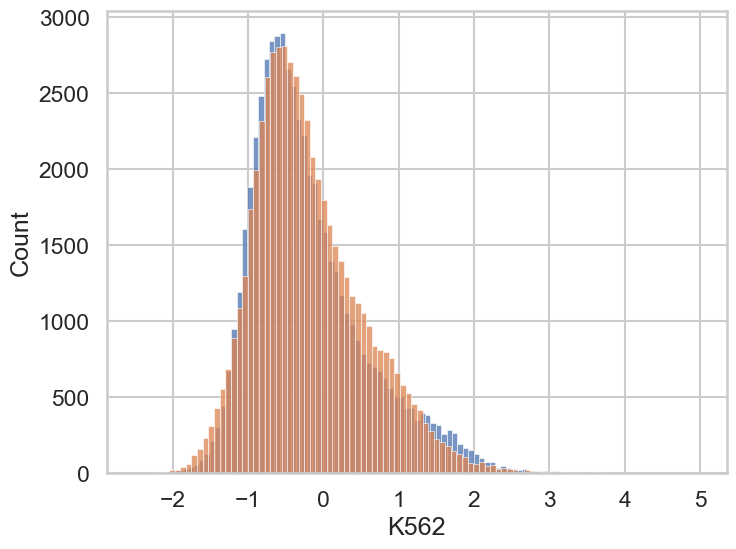

In [36]:
sns.histplot(MPRA_df['K562'], bins=100)
sns.histplot(MPRA_df['HepG2'], bins=100)

<Axes: xlabel='K562_DNase', ylabel='Count'>

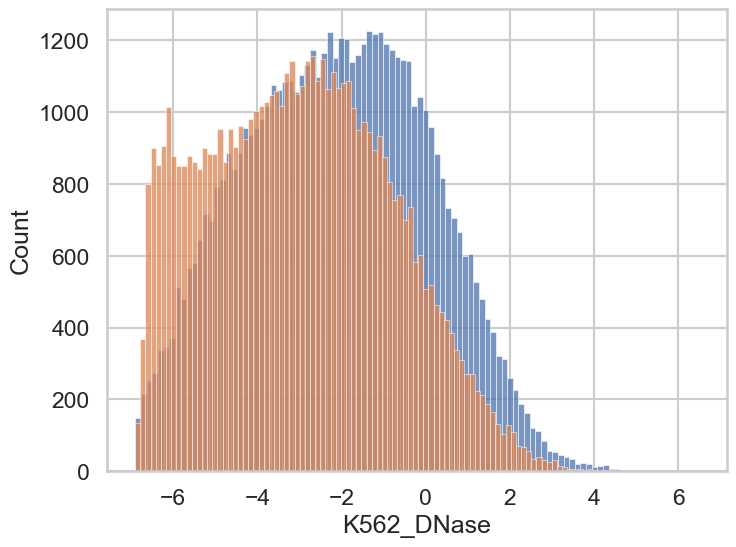

In [37]:
sns.histplot(MPRA_df['K562_DNase'], bins=100)
sns.histplot(MPRA_df['HepG2_DNase'], bins=100)

<Axes: xlabel='K562_H3K4me3', ylabel='Count'>

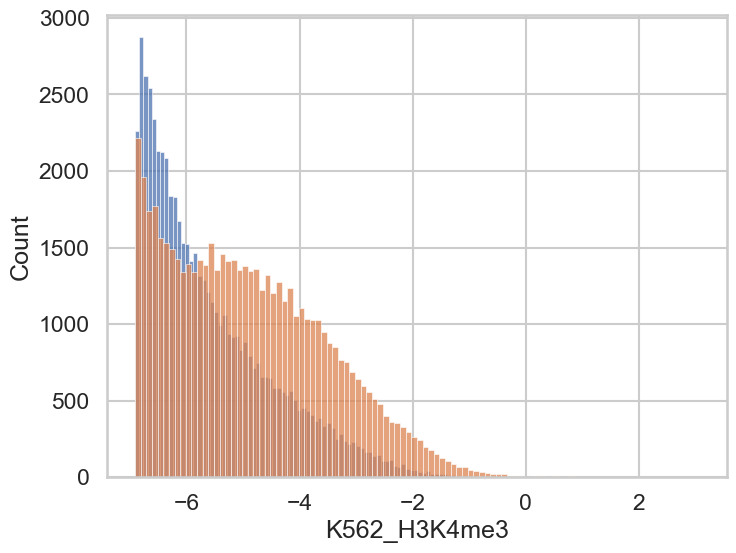

In [38]:
sns.histplot(MPRA_df['K562_H3K4me3'], bins=100)
sns.histplot(MPRA_df['HepG2_H3K4me3'], bins=100)

In [15]:
######### GosaiMPRA

pred_array = load_h5('outputs/GosaiMPRA_Sei_pred_long.h5')
pred_array = load_h5('outputs/GosaiMPRA_Sei_pred_long_new.h5') # float32 data type, result no difference
print(pred_array.shape)

(760679, 21907)


In [19]:
######### GosaiMPRA

pred_array = load_h5('outputs/GosaiMPRA_Sei_pred_long_new.h5')
print(pred_array.shape)

(760679, 21907)


In [16]:
MPRA_df = pd.read_csv('../data/GosaiMPRA/GosaiMPRA_my_processed_data_len200_norm.csv')
print(MPRA_df.shape)

(760679, 14)


In [29]:
def logit(x, eps=0):
    x = np.asarray(x, dtype=np.float64)
    x = np.clip(x, eps, 1 - eps)
    return np.log(x/(1-x))

In [44]:
# average every channel

cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
cell_names = ['K562_Leukemia_Cell', 'HepG2_Hepatocellular_Carcinoma', 'SK-N-SH_Neuroblastoma_cell_Brain', 'HCT-116_Colorectal_cancer_cell_line', 'A549']


pred_feature_matrix = np.full(shape=(len(pred_array), len(cell_types), len(assays)), fill_value=np.nan)

pearson_df = pd.DataFrame(index=cell_types, columns=assays, dtype=float)

np.full(shape=(len(cell_types), len(assays)), fill_value=np.nan)

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        indice = df_Sei_Siraj.loc[cell_names[i], assay]
        if isinstance(indice, list) and len(indice) > 0:
            for idx in indice:
                pred_feature = logit(pred_array[:, idx])
                true_label = MPRA_df[cell_type]
                r, _ = pearson(pred_feature, true_label)
                print(cell_type, assay, idx, r)

            pred_feature = logit(pred_array[:, indice], eps=0).mean(1)
            pred_feature_matrix[:, i, j] = pred_feature
            true_label = MPRA_df[cell_type]
            r, _ = pearson(pred_feature, true_label)
            pearson_df.loc[cell_type, assay] = r
            MPRA_df[f'{cell_type}_{assay}'] = pred_feature
        else:
            pred_feature_matrix[:, i, j] = np.nan
            MPRA_df[f'{cell_type}_{assay}'] = np.nan
            pearson_df.loc[cell_type, assay] = np.nan


pearson_df

K562 DNase 1490 0.5362989772319009
K562 DNase 2919 0.491952805333691
K562 DNase 3167 0.6298517396473462
K562 DNase 4632 0.5266611595204929
K562 DNase 4633 0.5431147043980566
K562 DNase 10715 0.5615075840063127
K562 DNase 10716 0.5468122478447767
K562 DNase 10717 0.562839111308217
K562 DNase 10718 0.5527407775913649
K562 DNase 10719 0.6065077357602382
K562 DNase 10720 0.5822355215313215
K562 DNase 10721 0.5695947374305617
K562 DNase 10722 0.5801798938158912
K562 DNase 10723 0.6150876022688754
K562 DNase 10724 0.5793967941248449
K562 DNase 10725 0.5803117626787933
K562 DNase 10726 0.5751955296436988
K562 DNase 10727 0.5172659351790677
K562 DNase 10728 0.5147819368263142
K562 DNase 10729 0.5838777312214496
K562 DNase 10730 0.6049432110101507
K562 DNase 10731 0.5439283218160167
K562 DNase 10732 0.5863701753513787
K562 DNase 10749 0.5690605578720966
K562 DNase 10817 0.5973757756327556
K562 DNase 10822 0.5738884131017772
K562 DNase 10857 0.6033464204011529
K562 DNase 10954 0.5429493535419905

,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
K562,0.572,0.451,0.388,-0.100,0.284,-0.070,0.079,0.394
HepG2,0.513,0.481,0.494,0.165,0.293,-0.094,0.061,0.383
SK-N-SH,0.521,0.501,0.540,0.047,NaN,-0.051,NaN,0.377
HCT116,0.554,0.569,0.576,0.393,0.569,-0.061,0.347,0.396
A549,0.341,0.344,0.374,0.071,0.293,-0.109,0.183,0.239


In [42]:
def cut_under_median(data):
    data = np.array(data)
    m = np.median(data)
    data[data < m] = m
    return data



cell_types = ['K562', 'HepG2', 'SK-N-SH', 'HCT116', 'A549']
assays = ['DNase', 'H3K4me3', 'H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'CTCF']

pearson_df = pd.DataFrame(index=cell_types, columns=assays, dtype=float)


for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        MPRA_df[f'{cell_type}_{assay}'] = cut_under_median(MPRA_df[f'{cell_type}_{assay}'])

        pred_feature = MPRA_df[f'{cell_type}_{assay}']
        true_label = MPRA_df[cell_type]
        r, _ = pearson(pred_feature, true_label)
        pearson_df.loc[cell_type, assay] = r

pearson_df


after remove nan, len(x) < 2, pearson = nan
after remove nan, len(x) < 2, pearson = nan


,DNase,H3K4me3,H3K27ac,H3K27me3,H3K4me1,H3K36me3,H3K9me3,CTCF
K562,0.638,0.563,0.518,-0.042,0.432,0.013,0.147,0.408
HepG2,0.569,0.544,0.558,0.293,0.393,-0.037,0.128,0.391
SK-N-SH,0.561,0.561,0.584,0.098,NaN,0.022,NaN,0.392
HCT116,0.605,0.619,0.622,0.481,0.606,-0.008,0.459,0.404
A549,0.457,0.418,0.453,0.151,0.406,-0.024,0.301,0.276


In [45]:
MPRA_df.to_csv('../data/GosaiMPRA/GosaiMPRA_seq_feature_0504.csv', index=False)

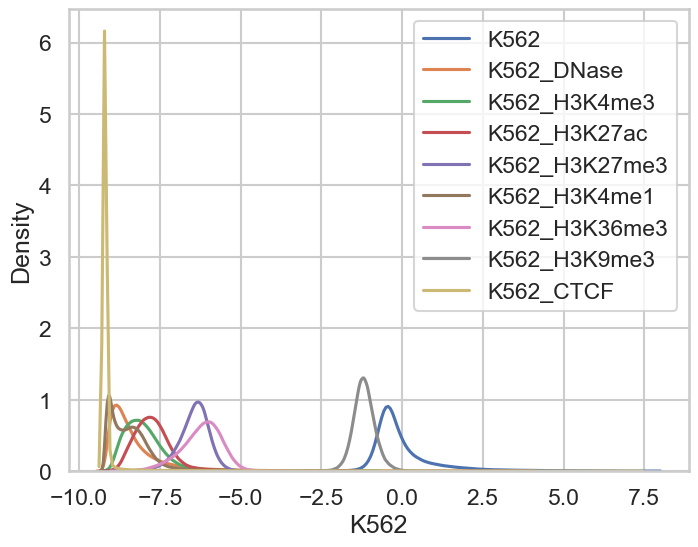

In [28]:
for col in MPRA_df.columns:
    if 'K562' in col:
        sns.kdeplot(MPRA_df[col], label=col)
plt.legend()